In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
#pip freeze > requirements.txt


In [3]:

# Step 1: Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:

# Function to scrape headlines and dates from Crypto News
def scrape_crypto_news():
    headlines = []
    dates = []
    for page in range(1, 15):
        url = f"https://crypto.news/page/{page}/?s=xrp"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        for h3, date_div in zip(soup.find_all('h3'), soup.find_all('div', class_='search-result-loop__date')):
            headline = h3.get_text()
            raw_date = date_div.get_text(strip=True).split(" at ")[0]  # Remove time
            parsed_date = datetime.strptime(raw_date, "%b %d, %Y").strftime('%d/%m/%Y')
            headlines.append(headline)
            dates.append(parsed_date)
    return headlines, dates


In [15]:

# Function to scrape titles and dates from The Crypto Basic
def scrape_crypto_basic():
    titles = []
    dates = []
    for page in range(1, 15):
        url = f"https://thecryptobasic.com/tag/ripple/page/{page}/"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        for a in soup.find_all('a'):
            title = a.find('h3')
            date_time = a.find('time', class_='entry-date updated td-module-date')
            if title and date_time:
                raw_date = date_time['datetime'].split("T")[0]  # Extract date part
                parsed_date = datetime.strptime(raw_date, "%Y-%m-%d").strftime('%d/%m/%Y')
                titles.append(title.get_text())
                dates.append(parsed_date)
    return titles, dates


In [16]:

# Function to scrape headlines and dates from Yahoo Finance
def scrape_yahoo_finance():
    yahoo_headlines = []
    dates = []
    url = "https://finance.yahoo.com/quote/XRP-USD/news/"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = soup.find_all('h3', class_='Mb(5px)')
    times = soup.find_all('div', class_='publishing yf-1weyqlp')

    for article, time_div in zip(articles[:50], times[:50]):  # Limit to 20 articles
        headline = article.get_text()
        time_text = time_div.get_text(strip=True).split("•")[-1].strip()
        # Calculate date from "XX hours/days ago"
        today = datetime.today()
        if "hour" in time_text:
            hours_ago = int(re.search(r"\d+", time_text).group())
            article_date = today - timedelta(hours=hours_ago)
        elif "day" in time_text:
            days_ago = int(re.search(r"\d+", time_text).group())
            article_date = today - timedelta(days=days_ago)
        elif "week" in time_text:
            weeks_ago = int(re.search(r"\d+", time_text).group())
            article_date = today - timedelta(weeks=weeks_ago)
        elif "month" in time_text:
            months_ago = int(re.search(r"\d+", time_text).group())
            article_date = today - timedelta(days=months_ago * 30)
        else:
            article_date = today

        parsed_date = article_date.strftime('%d/%m/%Y')
        yahoo_headlines.append(headline)
        dates.append(parsed_date)

    return yahoo_headlines, dates


In [17]:

# Step 2: Combine all scraped data
def combine_data():
    crypto_news_headlines, crypto_news_dates = scrape_crypto_news()
    crypto_basic_titles, crypto_basic_dates = scrape_crypto_basic()
    yahoo_finance_headlines, yahoo_finance_dates = scrape_yahoo_finance()

    all_headlines = crypto_news_headlines + crypto_basic_titles + yahoo_finance_headlines
    all_dates = crypto_news_dates + crypto_basic_dates + yahoo_finance_dates
    return all_headlines, all_dates

# The rest of the code remains the same except for updated visualization


In [18]:

# Step 6: Create a DataFrame and analyze sentiment
data = []
all_headlines, all_dates = combine_data()
for headline, date in zip(all_headlines, all_dates):
    cleaned_headline = re.sub(r'\W', ' ', headline.lower())
    textblob_score = TextBlob(cleaned_headline).sentiment.polarity
    vader_score = SentimentIntensityAnalyzer().polarity_scores(cleaned_headline)['compound']
    average_score = (textblob_score + vader_score) / 2
    sentiment_category = (
        "Bullish" if average_score >= 0.5 else
        "Slightly Bullish" if 0.2 < average_score < 0.4 else
        "Neutral" if -0.2 <= average_score <= 0.2 else
        "Slightly Bearish" if -0.5 <= average_score < -0.2 else
        "Bearish"
    )
    data.append({
        'headline': headline,
        'date': date,
        'textblob_score': textblob_score,
        'vader_score': vader_score,
        'average_score': average_score,
        'sentiment_category': sentiment_category
    })

df = pd.DataFrame(data)
# Step 7: Save the DataFrame to a CSV file
df.to_csv('crypto_headlines_sentiment_analysis.csv', index=False)


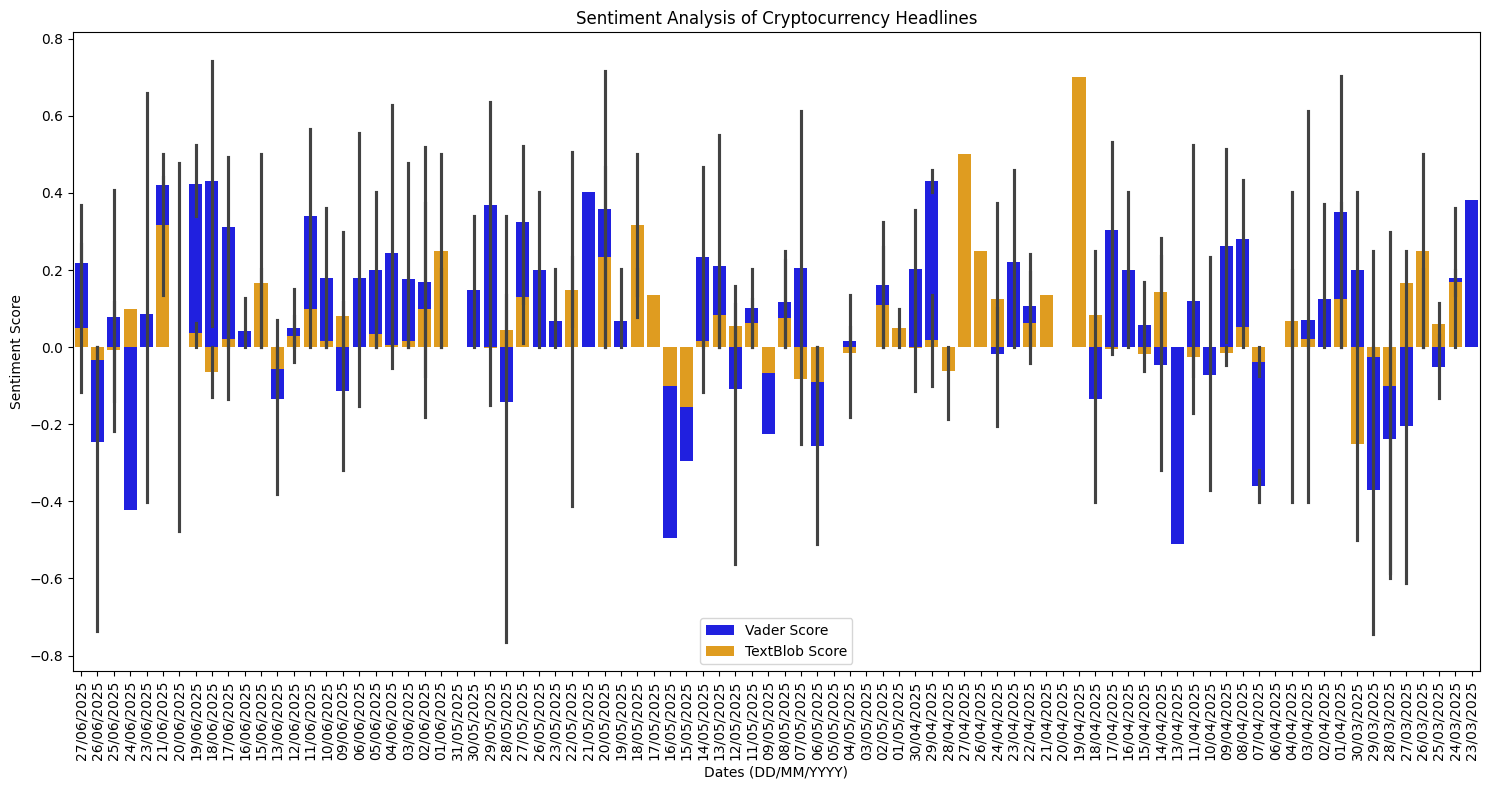

In [25]:

# Step 8: Visualization with date on the x-axis
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x="date", y="vader_score", data=df, color="blue", label="Vader Score", ax=ax)
sns.barplot(x="date", y="textblob_score", data=df, color="orange", label="TextBlob Score", ax=ax)

ax.set_title("Sentiment Analysis of Cryptocurrency Headlines")
ax.set_xlabel("Dates (DD/MM/YYYY)")
ax.set_ylabel("Sentiment Score")
ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for clarity
ax.legend()
# Create a visual space for the X axis

plt.tight_layout()
plt.show()


Descriptive Statistics:

       textblob_score  vader_score  average_score
count      252.000000   252.000000     252.000000
mean         0.043232     0.099060       0.071146
std          0.169013     0.316953       0.199953
min         -1.000000    -0.817600      -0.908800
25%          0.000000     0.000000       0.000000
50%          0.000000     0.000000       0.012900
75%          0.063920     0.345300       0.187075
max          0.700000     0.802000       0.592033


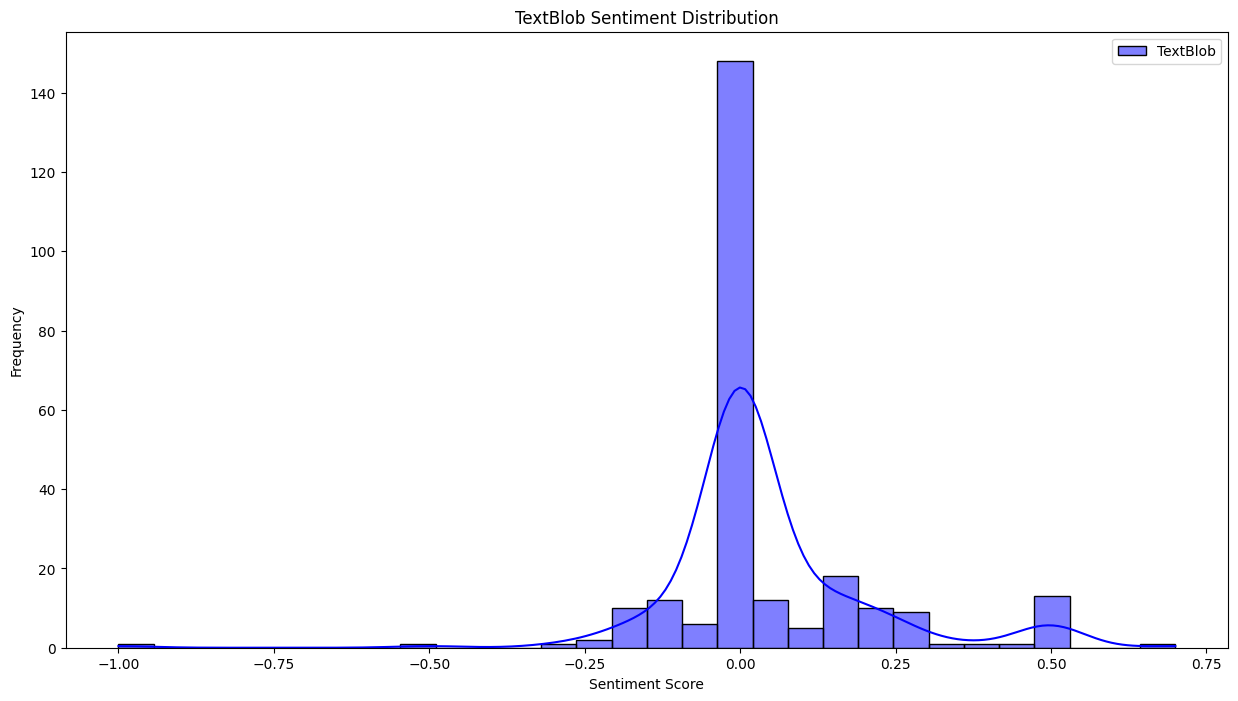

In [26]:

# Step 7: Descriptive Statistics
def descriptive_statistics():
    print("Descriptive Statistics:\n")
    print(df[['textblob_score', 'vader_score', 'average_score']].describe())

descriptive_statistics()

# Step 8: Sentiment Distribution Visualizations
# TextBlob Sentiment Distribution
plt.figure(figsize=(15, 8))
sns.histplot(df['textblob_score'], bins=30, kde=True, color='blue', label='TextBlob')
plt.title('TextBlob Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


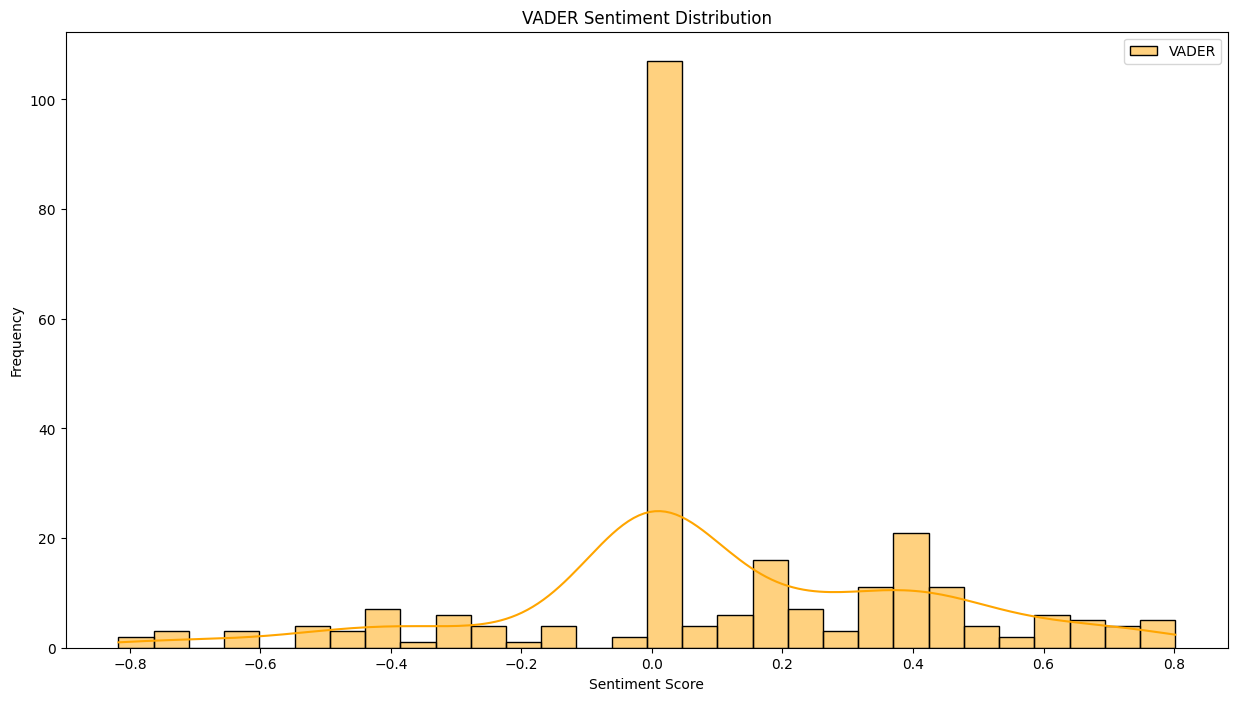

In [27]:

# VADER Sentiment Distribution
plt.figure(figsize=(15, 8))
sns.histplot(df['vader_score'], bins=30, kde=True, color='orange', label='VADER')
plt.title('VADER Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


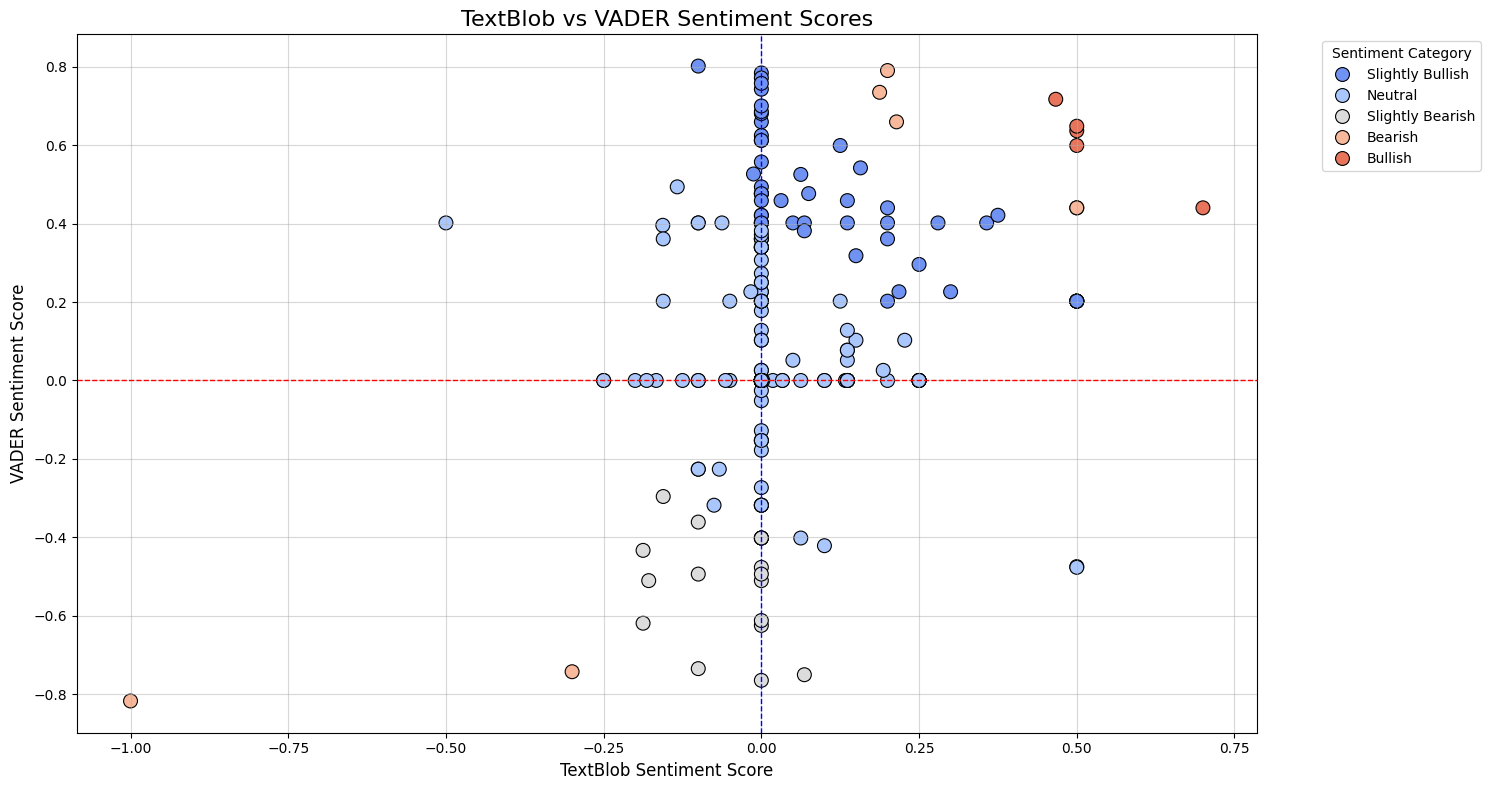

Descriptive statistics, sentiment distributions, and comparison visualization complete.


In [29]:

# TextBlob vs VADER Sentiment Scores
plt.figure(figsize=(15, 8))
scatter = sns.scatterplot(
    x='textblob_score',
    y='vader_score',
    data=df,
    hue='sentiment_category',
    palette='coolwarm',
    s=100,  # Adjust marker size
    edgecolor='black'  # Add an outline for better visibility
)

# Force all sentiment categories to appear in the legend
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, labels, title="Sentiment Category", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add titles and axis labels
plt.title('TextBlob vs VADER Sentiment Scores', fontsize=16)
plt.xlabel('TextBlob Sentiment Score', fontsize=12)
plt.ylabel('VADER Sentiment Score', fontsize=12)

# Add grid and axis lines for clarity
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='blue', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()


print("Descriptive statistics, sentiment distributions, and comparison visualization complete.")
